

# IoT Telemetry Data Analysis and Anomaly Detection

## Project overview

This project aimed to analyze and interpret IoT telemetry data, covering exploratory data analysis (EDA), time-series trends, anomaly detection, and predictive modeling. Through these analyses, we gained valuable insights into the behavior of different sensors, helping identify trends, unusual events, and potential device failures.

## Dataset Overview

The dataset, containing IoT telemetry data, includes the following key metrics:

temp: Temperature readings 

humidity: Humidity levels

co: CO gas concentration

smoke: Smoke levels

light: Light sensor readings

motion: Motion detection (binary indicator)

lpg: LPG gas levels

Each metric is recorded over time, allowing for a comprehensive temporal analysis of sensor performance and environmental conditions.

## Data Preprocessing

We'll begin by loading the telemetry dataset and then clean it by addressing any missing values, irrelevant columns, or inconsistencies. This will make the data ready for analysis, allowing us to extract reliable insights from clean, structured information.

In [1]:
import py4j
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Creating a Spark session
spark = SparkSession.builder \
    .appName("IoT Telemetry Data ") \
    .getOrCreate()

print(spark)

In [2]:
df = spark.read.csv('iot_telemetry_data.csv', header = True, inferSchema = True)

In [3]:
from pyspark.sql.functions import format_number

# Formating all numeric columns to show 2 decimal places
formatted_df = df.select([format_number(col, 2).alias(col) if dtype in ["double", "float"] else col for col, dtype in df.dtypes])
formatted_df.show(5)

+----------------+-----------------+----+--------+-----+----+------+-----+-----+
|              ts|           device|  co|humidity|light| lpg|motion|smoke| temp|
+----------------+-----------------+----+--------+-----+----+------+-----+-----+
|1,594,512,094.39|b8:27:eb:bf:9d:51|0.00|   51.00|false|0.01| false| 0.02|22.70|
|1,594,512,094.74|00:0f:00:70:91:0a|0.00|   76.00|false|0.01| false| 0.01|19.70|
|1,594,512,098.07|b8:27:eb:bf:9d:51|0.00|   50.90|false|0.01| false| 0.02|22.60|
|1,594,512,099.59|1c:bf:ce:15:ec:4d|0.00|   76.80| true|0.01| false| 0.02|27.00|
|1,594,512,101.76|b8:27:eb:bf:9d:51|0.00|   50.90|false|0.01| false| 0.02|22.60|
+----------------+-----------------+----+--------+-----+----+------+-----+-----+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- ts: double (nullable = true)
 |-- device: string (nullable = true)
 |-- co: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- light: boolean (nullable = true)
 |-- lpg: double (nullable = true)
 |-- motion: boolean (nullable = true)
 |-- smoke: double (nullable = true)
 |-- temp: double (nullable = true)



### Checking for null values

In [5]:
from pyspark.sql.functions import col,sum

df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns]).show()    

+---+------+---+--------+-----+---+------+-----+----+
| ts|device| co|humidity|light|lpg|motion|smoke|temp|
+---+------+---+--------+-----+---+------+-----+----+
|  0|     0|  0|       0|    0|  0|     0|    0|   0|
+---+------+---+--------+-----+---+------+-----+----+



### checking unique count

In [6]:
for col in df.columns:
    unique_count = df.select(col).distinct().count()
    print(f'Unique values in {col} is: {unique_count}')

Unique values in ts is: 405171
Unique values in device is: 3
Unique values in co is: 8319
Unique values in humidity is: 677
Unique values in light is: 2
Unique values in lpg is: 8319
Unique values in motion is: 2
Unique values in smoke is: 8319
Unique values in temp is: 231


## Data Exploration

In this step, we explore the data to understand its structure and key patterns. First, we calculate summary statistics to quickly grasp the mean, median, and spread of values. We then visualize distributions with histograms to observe each sensor metric’s range and variability, highlighting any unusual spikes or trends

Next, we analyze correlations to spot relationships between metrics, such as temperature and humidity, which will guide us in later analyses. Overall, EDA helps uncover initial insights and ensures we're ready for deeper analysis and anomaly detection.



In [7]:
df.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|                  ts|           device|                  co|          humidity|                 lpg|               smoke|              temp|
+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|              405184|           405184|              405184|            405184|              405184|              405184|            405184|
|   mean|1.5948580172968302E9|             NULL|0.004638844633116083| 60.51169396157432|0.007237125655057663|0.019263611784849165|22.453987345643576|
| stddev|  199498.39926321947|             NULL|0.001250026283485...|11.366489390798092|0.001444115678768...|0.004086130060122...| 2.698346951263275|
|    min|1.5945120943859746E9|00:0f:00:70:91:0a|0.001170508548437...| 1.100000023841858|0.0026934786

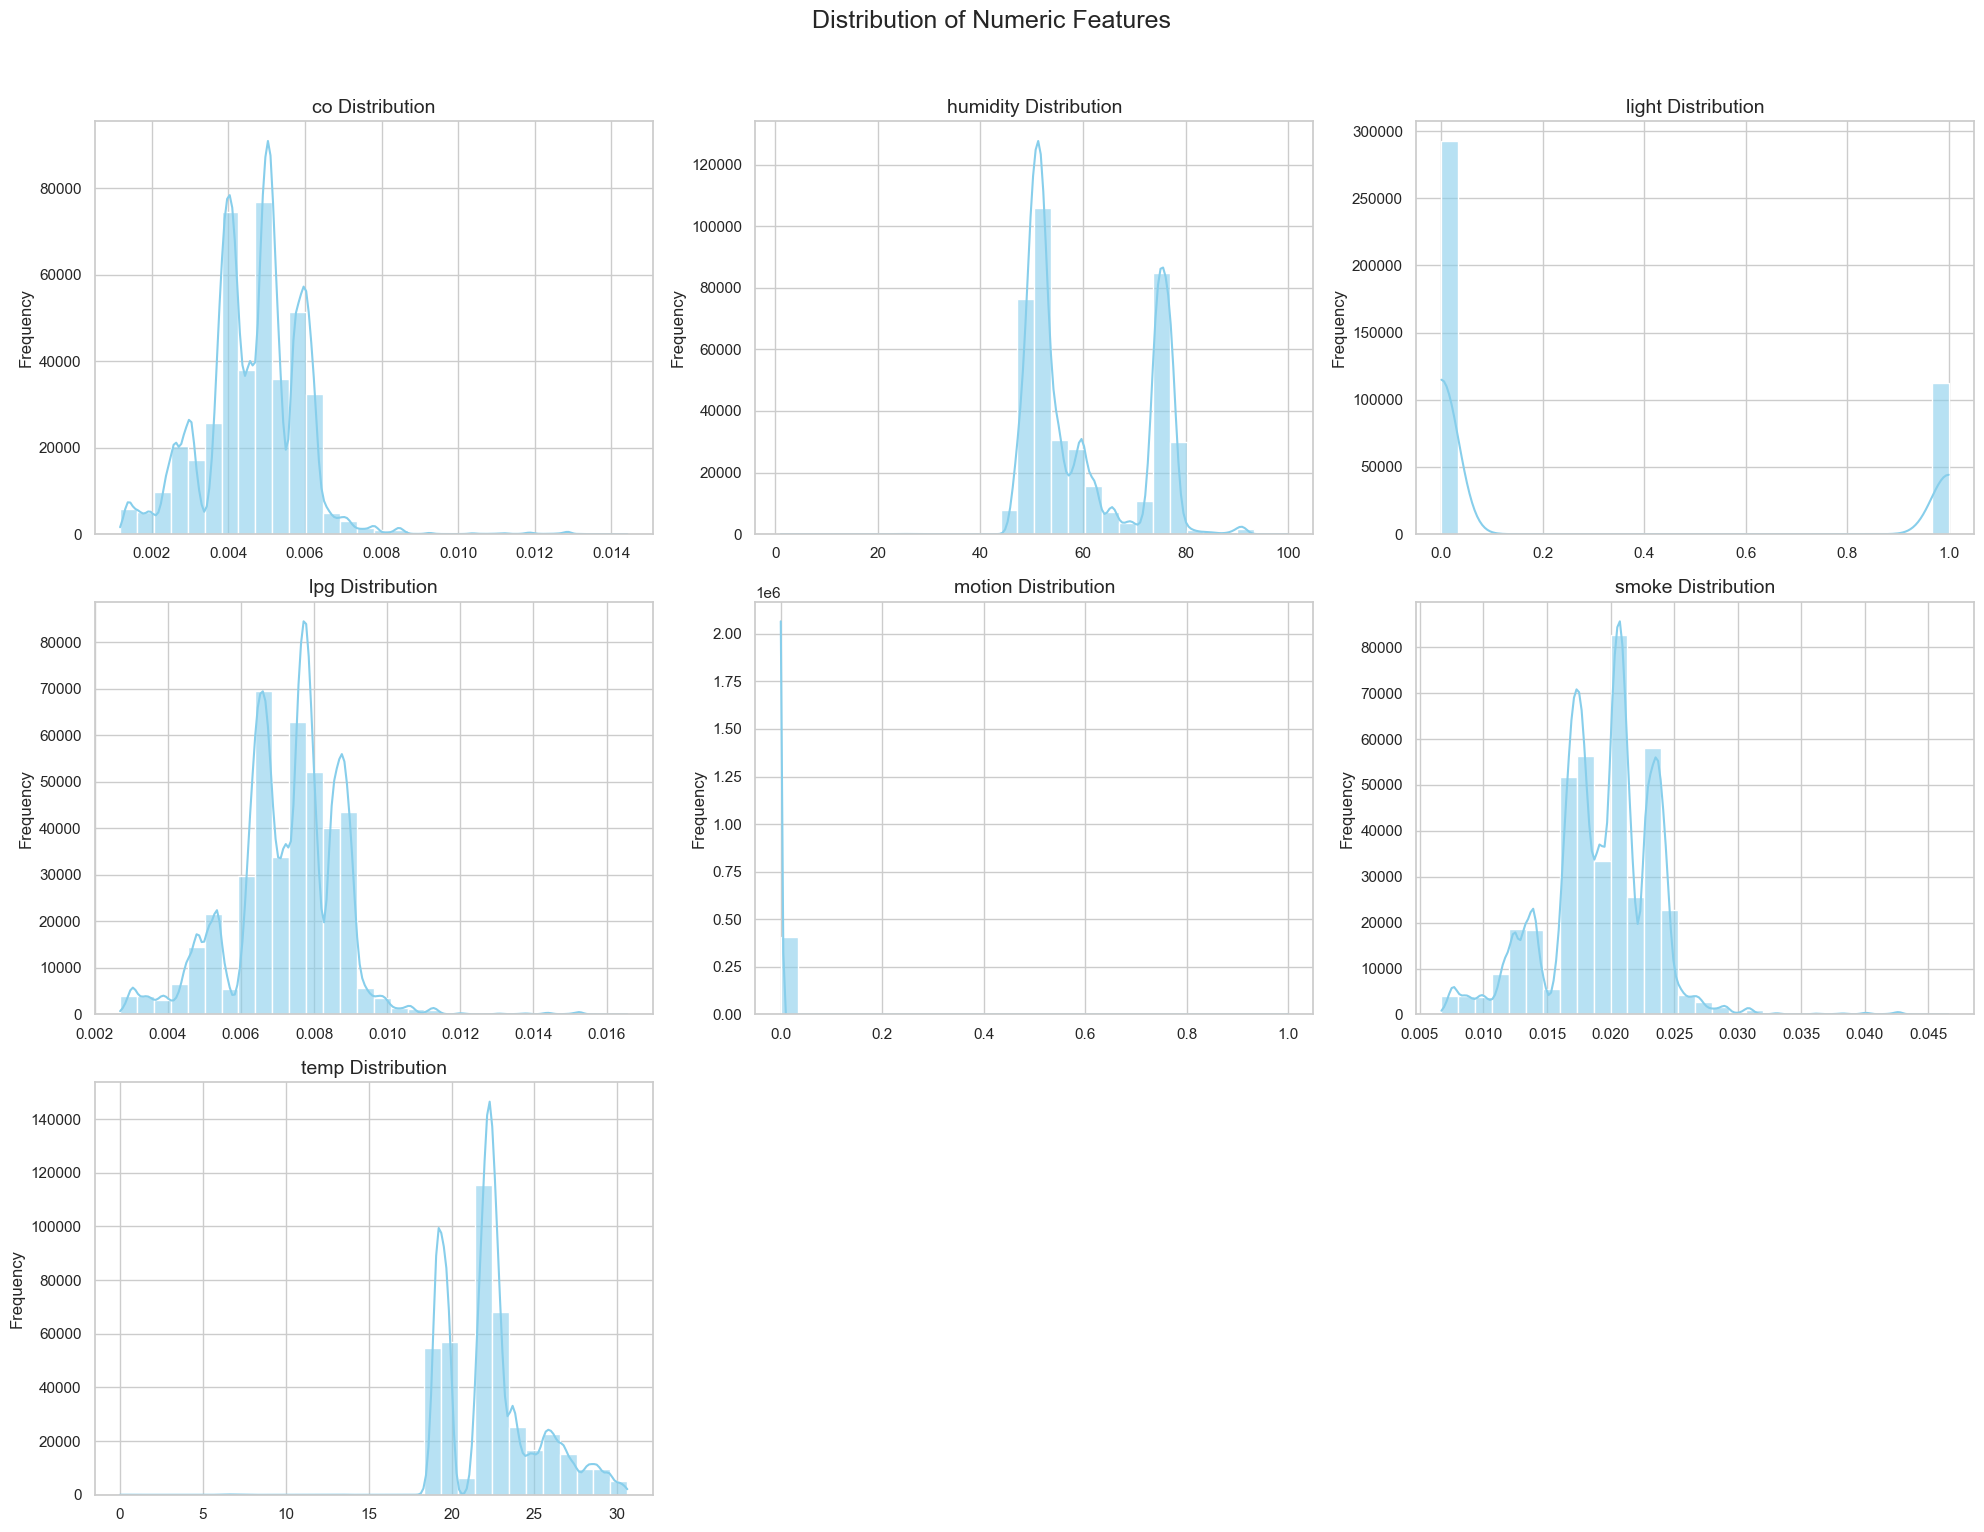

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converting to Pandas DataFrame and selecting numeric columns
df_pd = df.toPandas()
df_pd = df_pd.drop(columns=['ts'])
df_pd = df_pd.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
numeric_columns = df_pd.select_dtypes(include=['number']).columns

# Creating the figure and axes for subplots
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=(len(numeric_columns) + 2) // 3, ncols=3, figsize=(20, 15))
fig.suptitle('Distribution of Numeric Features', fontsize=18, y=1.02)

# Ploting each column in a subplot
for ax, column in zip(axes.flat, numeric_columns):
    sns.histplot(df_pd[column], bins=30, kde=True, ax=ax, color='skyblue', 
                 alpha=0.6)
    ax.set_title(f'{column} Distribution', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

# Removing empty subplots
for ax in axes.flat[len(numeric_columns):]:
    fig.delaxes(ax)

# Adjusting layout and display
plt.tight_layout()
plt.show()

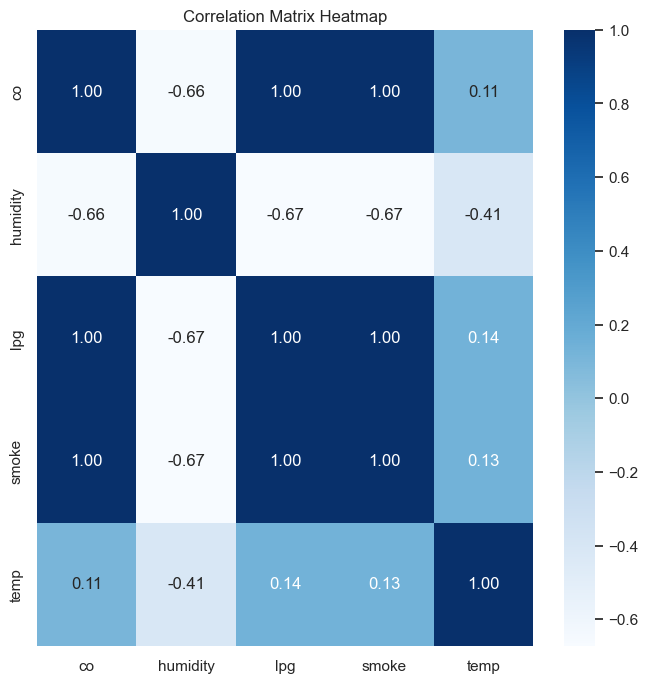

In [9]:
from pyspark.sql.functions import corr

numeric_columns = [col for col, dtype in df.dtypes if dtype in ("int", "double") and col != 'ts']

if not numeric_columns:
    print("No numeric columns found.")
else:
    # Calculating correlations for each pair of numeric columns
    correlations = {}
    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):
            col1, col2 = numeric_columns[i], numeric_columns[j]
            value = df.stat.corr(col1, col2)
            correlations[(col1, col2)] = value

    # Converting to pandas DataFrame for easy visualization
    import pandas as pd
    correlation_matrix = pd.DataFrame(index=numeric_columns, columns=numeric_columns)
    
    for (col1, col2), value in correlations.items():
        correlation_matrix.loc[col1, col2] = value
        correlation_matrix.loc[col2, col1] = value
    
    # Filling diagonal with 1s (self-correlation)
    correlation_matrix.fillna(1, inplace=True)
    
    # Plotting the correlation heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Correlation Matrix Heatmap')
    plt.show()


In [10]:
# Saving the dataset as a csv for the next notebook
import pandas as pd
cleaned_data = df.toPandas()
cleaned_data['ts'] = pd.to_datetime(cleaned_data['ts'])
cleaned_data.to_csv('cleaned_data.csv', index=False)

In [11]:
# closing the pyspark session
spark.stop()